In [1]:
import numpy as np
import pandas as pd
import random
import os
from os.path import join
import datetime
import time

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
import numpy as np

def ND(prediction, Y, mask=None):
    if mask is None:
        mask = np.array((~np.isnan(Y)).astype(int))
    Y[mask == 0] = 0.
    return abs((prediction - Y) * mask).sum() / abs(Y).sum()

def NRMSE(prediction, Y, mask=None):
    if mask is None:
        mask = np.array((~np.isnan(Y)).astype(int))
    Y[mask == 0] = 0.
    return pow((pow(prediction - Y, 2) * mask).sum(), 0.5) / abs(Y).sum() * pow(mask.sum(), 0.5)

In [3]:
def get_slice(data, T_train, T_test, T_start, normalize=True):
    N = len(data)
    # split on train and test
    train = data[:, T_start:T_start+T_train].copy()
    test = data[:, T_start+T_train:T_start+T_train+T_test].copy()

    # normalize data
    if normalize:
        mean_train = np.array([])
        std_train = np.array([])
        for i in range(len(train)):
            if (~np.isnan(train[i])).sum() == 0:
                mean_train = np.append(mean_train, 0)
                std_train = np.append(std_train, 0)
            else:
                mean_train = np.append(mean_train, train[i][~np.isnan(train[i])].mean())
                std_train = np.append(std_train, train[i][~np.isnan(train[i])].std())
        
        std_train[std_train == 0] = 1.

        train -= mean_train.repeat(T_train).reshape(N, T_train)
        train /= std_train.repeat(T_train).reshape(N, T_train)
        test -= mean_train.repeat(T_test).reshape(N, T_test)
        test /= std_train.repeat(T_test).reshape(N, T_test)
    
    return train, test

def RollingCV(model, data, T_train, T_test, T_step, metric='ND', normalize=True):
    scores = np.array([])
    for T_start in range(0, data.shape[1]-T_train-T_test+1, T_step):
        train, test = get_slice(data, T_train, T_test, T_start, normalize=normalize)
        model.fit(train)
        test_preds = model.predict(T_test)
        if metric == 'ND':
            scores = np.append(scores, ND(test_preds, test))
        if metric == 'NRMSE':
            scores = np.append(scores, NRMSE(test_preds, test))
    return scores

In [4]:
folders = os.listdir('../../history')

def get_filename(foldername, time='day'):
    filename = '{}_{}_1.csv'.format(foldername, time)
    return join('../../history', foldername, time, filename)

In [153]:
from datetime import timezone
import datetime

time_type_to_seconds = {
    "day": 60*60*24,
    "fiveMin": 60*5,
    "hour": 60*60,
    "oneMin": 60,
    "thirtyMin": 60*30
}

def get_timestamp_for_date(date_to_check, date_type="day"):
    dt = datetime.datetime.strptime(date_to_check, '%d/%m/%Y %H:%M:%S')
    dt = dt.replace(tzinfo=timezone.utc)
    if date_type != "day":
        dt -= datetime.timedelta(hours=3)
    return int(dt.timestamp())

def get_data_for_specific_time(date, date_type="day", number_of_data=200):
    first_timestamp = get_timestamp_for_date(date, date_type)
    last_timestamp = first_timestamp + number_of_data * time_type_to_seconds[date_type]
    timeline = range(first_timestamp, last_timestamp, time_type_to_seconds[date_type])
    data = pd.DataFrame(data={'TU': timeline})
    dict_crypto_name = {}

    # join all series for O, C, H, L
    for i in range(len(folders)):
        series = pd.read_csv(get_filename(folders[i], date_type), sep=';', decimal=',')[['TU', 'O', 'C', 'H', 'L']]
        name_columns = ['Open price', 'Close price', 'High price', 'Low price']
        for j in range(i*4, (i+1)*4):
            dict_crypto_name[j] = (name_columns[j-i*4], folders[i])
        data = pd.merge(data, series, how='left', on='TU')

    # transpose
    data = data.values[:,1:].T.astype(float)
    print("Data shape: ", data.shape)
    return data, dict_crypto_name

In [33]:
def interpolate_data(data):
    data_interpolated = data.copy()

    N, T = data_interpolated.shape
    total = 0
    for i in range(N):
        start = 0
        end = 0
        move = 'start'
        fill = False

        for t in range(T):
            if (move == 'start') and (np.isnan(data_interpolated[i][start])):
                move = 'end'
                end = start
                if start > 0:
                    a = data_interpolated[i][start-1]
                else:
                    a = 0
            if (move == 'end') and (~np.isnan(data_interpolated[i][end]) or (end == T-1)):
                b = data_interpolated[i][end]
                fill = True

            if fill:
                if np.isnan(b):
                    b = 0
                for j in range(start, end):
                    total += 1
                    data_interpolated[i][j] = a + (j-start)*(b-a)/(end-start)
                fill = False
                move = 'start'
                start = end

            if move == 'start':
                start += 1
            else:
                end += 1

    data_interpolated[np.isnan(data_interpolated)] = 0.
    return data_interpolated

# Data preparations

In [154]:
# prepare timeline
start_date = "01/01/2017 00:00:00"

data, dict_crypto_name = get_data_for_specific_time(start_date, "day", 200)
data_interpolated = interpolate_data(data)

Data shape:  (856, 200)


In [37]:
# save data
np.savetxt('merged_transposed_series.csv', data, delimiter=';')

In [155]:
print("Percentage of missing data = {}%".format(int((np.isnan(data)).sum() / (data.shape[0]*data.shape[1]) * 100)))

Percentage of missing data = 30%


In [40]:
def draw_plot(true_data, index_to_check, pred_data = []):

    plt.figure(figsize=(15,8))
    plt.plot(true_data, color='blue')
    if len(pred_data) > 0:
        plt.plot(pred_data, color='red')
    plt.title("% of %s"%dict_crypto_name[index_to_check])

    plt.xlabel('timepoint')
    plt.ylabel('value')

    plt.show()

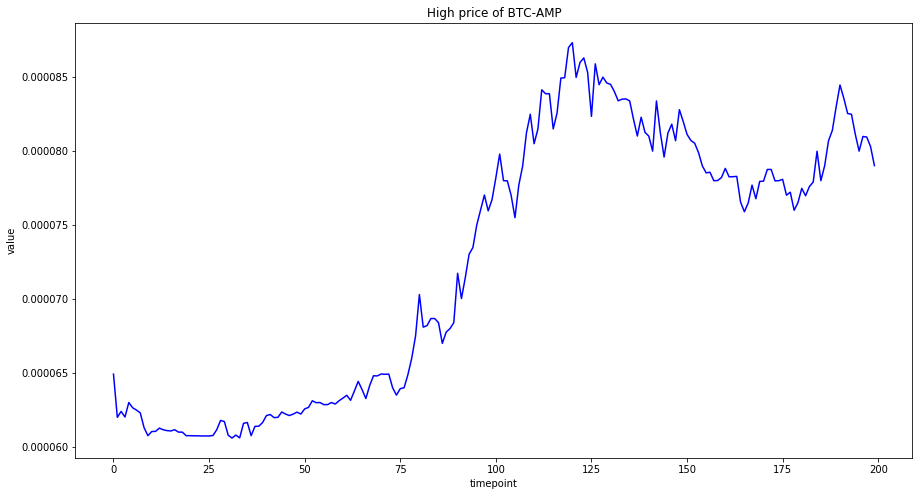

In [102]:
draw_plot(data_interpolated[34],34)

In [42]:
def draw_test_plot(model, index_to_check):

    model.fit(data_interpolated[:,:-20])
    pred_vals = model.predict(20)

    draw_plot(data_interpolated[index_to_check][-20:], index_to_check, pred_data=pred_vals[index_to_check])

# Autoregressive models for each of feature of our dataset.
The most good lags parameter was 1 for such kind of the model, but it works mostly for prediction nearest values (h = 1,5,10), but if we want farther predictions, this model doesn't fit.

In [42]:
class IndependentFeaturesAutoRegressionModel():
    """ Forecasting with n independent AR models for timeseries with lags """
    def __init__(self, lags):
        self.lags = lags

    def fit(self, train):
        self.train = train
        self.coefs = []
        self.intercept = []

        for index in range(len(train)):
            series = train[index]
            features = [np.roll(series, shift=lag+1) for lag in range(self.lags)]
            
            X = np.vstack([features])
            model = LinearRegression()
            model.fit(X[:,self.lags:].T, series[self.lags:])
            self.intercept.append(model.intercept_)
            self.coefs.append(model.coef_)

    def predict(self, h):
        preds = []
        for index in range(len(self.train)):
            series = self.train[index]
            for _ in range(h):
                features = np.array([series[-(lag+1)] for lag in range(self.lags)])
                pred = (self.coefs[index] * features).sum() + self.intercept[index]
                series = np.append(series, pred)
            preds.append(series[-h:])
        return np.vstack(preds)

In [156]:
errors_ind_ar = []
for lags in [1, 7, 14, 30]:
    temp = []
    for h in [1, 5, 10, 20]:
        model = IndependentFeaturesAutoRegressionModel(lags)
        scores_nd = RollingCV(model, data_interpolated, T-h, h, T_step=1, metric='ND')
        scores_nrmse = RollingCV(model, data_interpolated, T-h, h, T_step=1, metric='NRMSE')
        print('Independent AR performance ND/NRMSE (h = {}, lags = {}): {}/{}'.format(h,lags, round(np.array(scores_nd).mean(),3),\
                                                                   round(np.array(scores_nrmse).mean(),3))) 
        temp.append((round(np.array(scores_nd).mean(),3), round(np.array(scores_nrmse).mean(),3)))
    errors_ind_ar.append(temp)

Independent AR performance ND/NRMSE (h = 1, lags = 1): 0.161/0.294
Independent AR performance ND/NRMSE (h = 5, lags = 1): 0.349/1.006
Independent AR performance ND/NRMSE (h = 10, lags = 1): 0.568/1.696
Independent AR performance ND/NRMSE (h = 20, lags = 1): 0.688/1.723
Independent AR performance ND/NRMSE (h = 1, lags = 7): 1.787/34.88
Independent AR performance ND/NRMSE (h = 5, lags = 7): 1455.073/50113.383
Independent AR performance ND/NRMSE (h = 10, lags = 7): 202598991617281.03/1.1509910434699976e+16
Independent AR performance ND/NRMSE (h = 20, lags = 7): 3.4652267521482915e+33/2.3886186000293217e+35
Independent AR performance ND/NRMSE (h = 1, lags = 14): 180025.664/5266922.94
Independent AR performance ND/NRMSE (h = 5, lags = 14): 4351711684.612/175102900478.333
Independent AR performance ND/NRMSE (h = 10, lags = 14): 275274809403015.22/1.6525804457069948e+16
Independent AR performance ND/NRMSE (h = 20, lags = 14): 1.7101226345862664e+34/1.4559957635297686e+36
Independent AR perfor

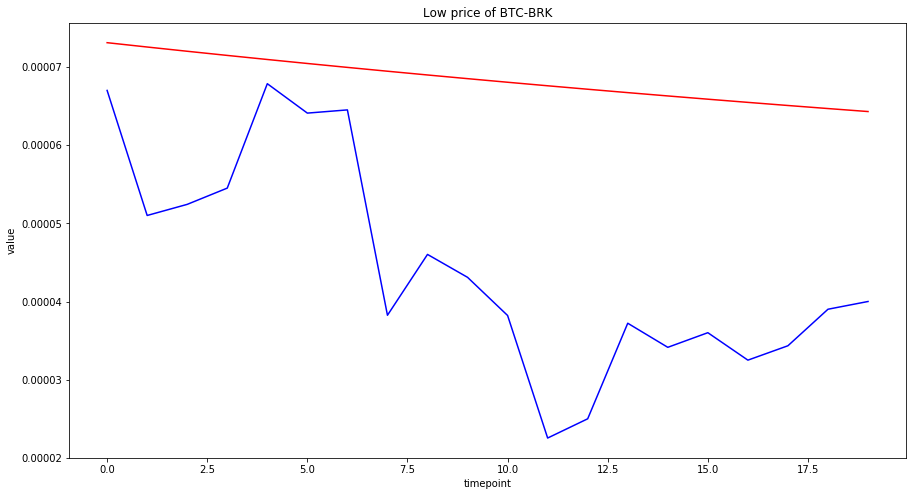

In [157]:
draw_test_plot(IndependentFeaturesAutoRegressionModel(1), 95)

# Autoregressive model for all taken features together
The result showed that with increasing lags number we have better accuracy. 

In [158]:
from statsmodels.tsa.vector_ar.var_model import VAR

class AutoRegressionModel():
    """ Forecasting with AR model for each timeseries with lags """
    def __init__(self, lags):
        self.lags = lags

    def fit(self, train):
        self.train = train.T
        self.model = VAR(endog=self.train)
        self.model_fit = self.model.fit(maxlags=self.lags, trend='nc')

    def predict(self, h):
        res = self.model_fit.forecast(self.model_fit.y[-self.model_fit.k_ar:,:], steps=h)
        return res.T

In [159]:
errors_ar = []
for lags in [1,7,14,30]:
    temp = []
    for h in [1, 5, 10, 20]:
        model = AutoRegressionModel(lags)
        scores_nd = RollingCV(model, data_interpolated, T-h, h, T_step=1, metric='ND')
        scores_nrmse = RollingCV(model, data_interpolated, T-h, h, T_step=1, metric='NRMSE')
        print('AR performance ND/NRMSE (h = {}, lags = {}): {}/{}'.format(h,lags, round(np.array(scores_nd).mean(),3),\
                                                               round(np.array(scores_nrmse).mean(),3))) 
        temp.append((round(np.array(scores_nd).mean(),3), round(np.array(scores_nrmse).mean(),3)))
    errors_ar.append(temp)

C:\Users\Asus\Anaconda3_new\lib\site-packages\statsmodels\tsa\vector_ar\var_model.py:461: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  params = np.linalg.lstsq(z, y_sample)[0]


AR performance ND/NRMSE (h = 1, lags = 1): 1.805/2.217
AR performance ND/NRMSE (h = 5, lags = 1): 1.743/2.234
AR performance ND/NRMSE (h = 10, lags = 1): 1.652/2.61
AR performance ND/NRMSE (h = 20, lags = 1): 1.447/2.029
AR performance ND/NRMSE (h = 1, lags = 7): 0.292/0.434
AR performance ND/NRMSE (h = 5, lags = 7): 0.771/1.252
AR performance ND/NRMSE (h = 10, lags = 7): 1.204/2.351
AR performance ND/NRMSE (h = 20, lags = 7): 1.531/2.178
AR performance ND/NRMSE (h = 1, lags = 14): 0.233/0.361
AR performance ND/NRMSE (h = 5, lags = 14): 0.64/1.041
AR performance ND/NRMSE (h = 10, lags = 14): 0.889/2.049
AR performance ND/NRMSE (h = 20, lags = 14): 1.263/1.936
AR performance ND/NRMSE (h = 1, lags = 30): 0.237/0.376
AR performance ND/NRMSE (h = 5, lags = 30): 0.452/0.836
AR performance ND/NRMSE (h = 10, lags = 30): 0.563/1.785
AR performance ND/NRMSE (h = 20, lags = 30): 0.596/1.291


C:\Users\Asus\Anaconda3_new\lib\site-packages\statsmodels\tsa\vector_ar\var_model.py:461: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  params = np.linalg.lstsq(z, y_sample)[0]


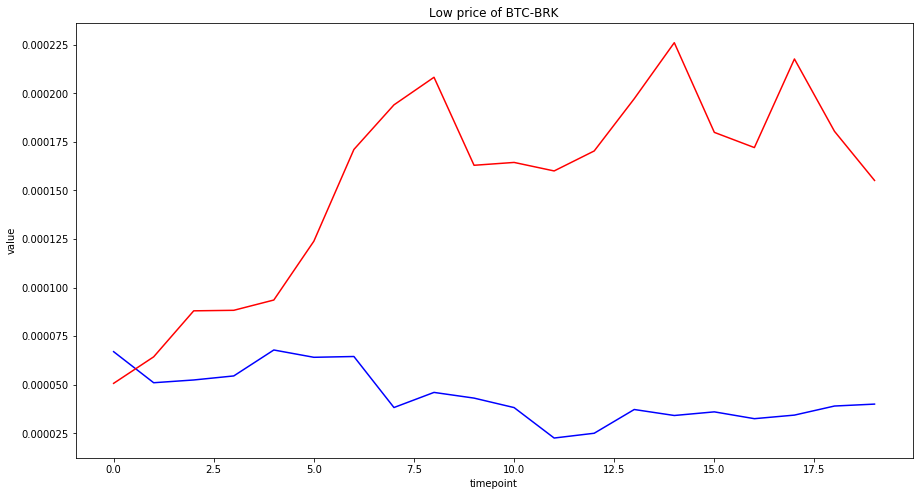

In [160]:
draw_test_plot(AutoRegressionModel(30), 95)

# Autoregressive model for each cryptocurrency (4 crypto features are taken together)
The results showed that this model doesn't converge, and accuracy is bad (probably I have an error)

In [161]:
from statsmodels.tsa.vector_ar.var_model import VAR

class OneCryptoFeaturesAutoRegressionModel():
    """ Forecasting with AR model for each crypto by features with lags """
    def __init__(self, lags, offset_features):
        self.lags = lags
        self.offset_features = offset_features

    def fit(self, train):
        self.n_models = []
        for crypto_num in range(train.shape[0]//self.offset_features):
            train_part = train[crypto_num*self.offset_features:(crypto_num+1)*self.offset_features].T
            model = VAR(endog=train_part)
            model_fit = model.fit(maxlags=self.lags, trend='nc')
            self.n_models.append(model_fit)

    def predict(self, h):
        res_total = []
        for model in self.n_models:
            res_total.append(model.forecast(model.y[-model.k_ar:,:], steps=h))
        return np.hstack(res_total).T

In [162]:
errors_crypto_ar = []
for lags in [1,7,14,30]:
    temp = []
    for h in [1, 5, 10, 20]:
        model = OneCryptoFeaturesAutoRegressionModel(lags,4)
        scores_nd = RollingCV(model, data_interpolated, T-h, h, T_step=1, metric='ND')
        scores_nrmse = RollingCV(model, data_interpolated, T-h, h, T_step=1, metric='NRMSE')
        print('One crypto info AR performance ND/NRMSE (h = {}, lags = {}): {}/{}'.format(h, lags, round(np.array(scores_nd).mean(),3),\
                                                               round(np.array(scores_nrmse).mean(),3))) 
        temp.append((round(np.array(scores_nd).mean(),3), round(np.array(scores_nrmse).mean(),3)))
    errors_crypto_ar.append(temp)

C:\Users\Asus\Anaconda3_new\lib\site-packages\statsmodels\tsa\vector_ar\var_model.py:461: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  params = np.linalg.lstsq(z, y_sample)[0]


One crypto info AR performance ND/NRMSE (h = 1, lags = 1): 68835205818.963/951256437132.899
One crypto info AR performance ND/NRMSE (h = 5, lags = 1): 3.825497001554732e+33/8.437347291434508e+34
One crypto info AR performance ND/NRMSE (h = 10, lags = 1): 1.2940480060312295e+58/5.313660064129505e+59
One crypto info AR performance ND/NRMSE (h = 20, lags = 1): 2.014841352451408e+116/1.2412590552522134e+118
One crypto info AR performance ND/NRMSE (h = 1, lags = 7): 115345849733.415/1808444435244.642
One crypto info AR performance ND/NRMSE (h = 5, lags = 7): 1.0791507794998103e+27/4.361233377011676e+28
One crypto info AR performance ND/NRMSE (h = 10, lags = 7): 2.19045839507854e+58/1.0794659604394145e+60
One crypto info AR performance ND/NRMSE (h = 20, lags = 7): 4.252658872053799e+55/3.210978626978368e+57
One crypto info AR performance ND/NRMSE (h = 1, lags = 14): 186554658248.872/1367159356665.89
One crypto info AR performance ND/NRMSE (h = 5, lags = 14): 2.343131979559813e+32/1.026521217

C:\Users\Asus\Anaconda3_new\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in square
  del sys.path[0]


C:\Users\Asus\Anaconda3_new\lib\site-packages\statsmodels\tsa\vector_ar\var_model.py:461: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  params = np.linalg.lstsq(z, y_sample)[0]


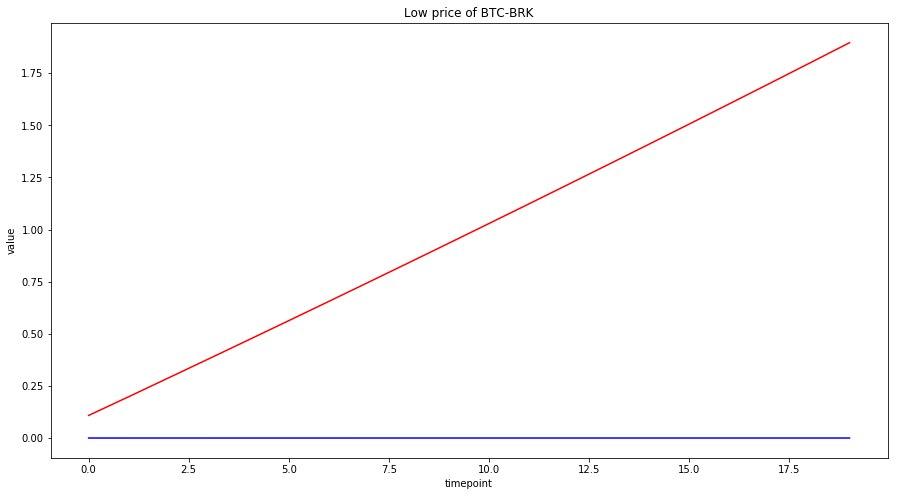

In [163]:
draw_test_plot(OneCryptoFeaturesAutoRegressionModel(1,4), 95)

# Autoregression model with prior SVD dimension reduction for all features together
The results showed worse accuracy that just Autoregressive model, but with increasing number of lags considered accuracy is improving.

In [164]:
from statsmodels.tsa.vector_ar.var_model import VAR

class SvdAutoRegressionModel():
    """ Forecasting with AR model for each crypto by features with lags """
    def __init__(self, lags):
        self.lags = lags
    
    def fit(self, train):
        u, s, vh = np.linalg.svd(train, full_matrices=False)
        self.F = u*s
        self.V = vh
        self.model = VAR(endog=self.V)
        self.model_fit = self.model.fit(maxlags=self.lags, trend='nc')

    def predict(self, h):
        res = self.model_fit.forecast(self.model_fit.y[-self.model_fit.k_ar:,:], steps=h)
        res = np.dot(self.F,res.T)
        return res

In [165]:
errors_svd_ar = []
for lags in [1,7,14,30]:
    temp = []
    for h in [1, 5, 10, 20]:
        model = SvdAutoRegressionModel(lags)
        scores_nd = RollingCV(model, data_interpolated, T-h, h, T_step=1, metric='ND')
        scores_nrmse = RollingCV(model, data_interpolated, T-h, h, T_step=1, metric='NRMSE')
        print('SVD AR performance ND/NRMSE (h = {}, lags = {}): {}/{}'.format(h, lags, round(np.array(scores_nd).mean(),3),\
                                                               round(np.array(scores_nrmse).mean(),3))) 
        temp.append((round(np.array(scores_nd).mean(),3), round(np.array(scores_nrmse).mean(),3)))
    errors_svd_ar.append(temp)

C:\Users\Asus\Anaconda3_new\lib\site-packages\statsmodels\tsa\vector_ar\var_model.py:461: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  params = np.linalg.lstsq(z, y_sample)[0]


SVD AR performance ND/NRMSE (h = 1, lags = 1): 1.499/1.91
SVD AR performance ND/NRMSE (h = 5, lags = 1): 2.714/3.424
SVD AR performance ND/NRMSE (h = 10, lags = 1): 4.258/5.576
SVD AR performance ND/NRMSE (h = 20, lags = 1): 2.193/2.91
SVD AR performance ND/NRMSE (h = 1, lags = 7): 1.01/1.362
SVD AR performance ND/NRMSE (h = 5, lags = 7): 1.094/1.528
SVD AR performance ND/NRMSE (h = 10, lags = 7): 1.059/2.098
SVD AR performance ND/NRMSE (h = 20, lags = 7): 0.998/1.599
SVD AR performance ND/NRMSE (h = 1, lags = 14): 1.018/1.375
SVD AR performance ND/NRMSE (h = 5, lags = 14): 1.065/1.516
SVD AR performance ND/NRMSE (h = 10, lags = 14): 1.082/2.116
SVD AR performance ND/NRMSE (h = 20, lags = 14): 1.049/1.64
SVD AR performance ND/NRMSE (h = 1, lags = 30): 1.03/1.391
SVD AR performance ND/NRMSE (h = 5, lags = 30): 1.049/1.511
SVD AR performance ND/NRMSE (h = 10, lags = 30): 1.056/2.103
SVD AR performance ND/NRMSE (h = 20, lags = 30): 1.033/1.627


C:\Users\Asus\Anaconda3_new\lib\site-packages\statsmodels\tsa\vector_ar\var_model.py:461: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  params = np.linalg.lstsq(z, y_sample)[0]


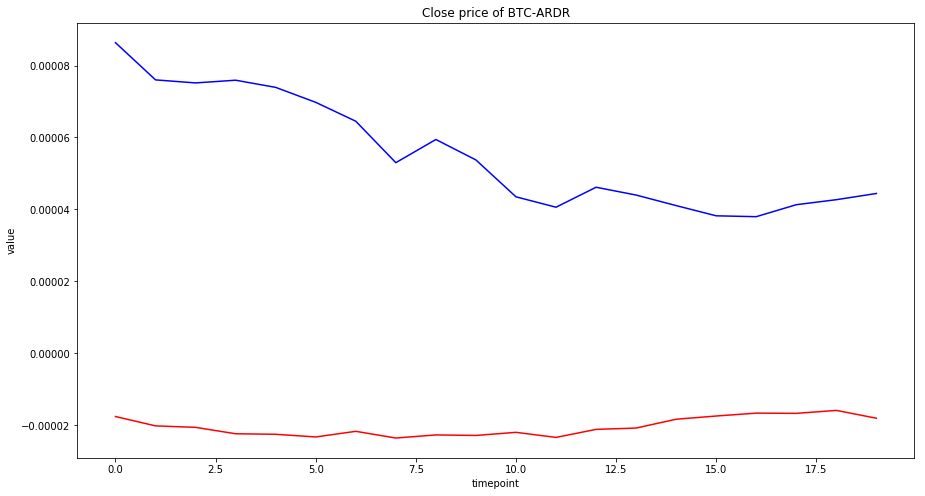

In [169]:
draw_test_plot(SvdAutoRegressionModel(7), 45)

# Simple TRMF model

The results so far worse than Autoregressive model because of algorithm's simpleness and small number of iterations.

In [170]:
from trmf import TRMF

lags = [1, 7, 14, 30]
rank = 256
lambda_f = 0.001
lambda_x = 0.01
lambda_w = 0.0001
alpha = 1000.
eta = 0.
num_iter = 200

In [171]:
for h in [1, 5, 10, 20]:
    model = TRMF(lags, rank, lambda_f, lambda_x, lambda_w, alpha, eta, num_iter)
    scores_nd = RollingCV(model, data, T - h, h, T_step=1, metric='ND')
    scores_nrmse = RollingCV(model, data, T - h, h, T_step=1, metric='NRMSE')
    print('TRMF performance ND/NRMSE (h = {}): {}/{}'.format(h, round(np.array(scores_nd).mean(), 3), \
                                                             round(np.array(scores_nrmse).mean(), 3)))

TRMF performance ND/NRMSE (h = 1): 1.043/1.594
TRMF performance ND/NRMSE (h = 5): 1.028/13.215
TRMF performance ND/NRMSE (h = 10): 1.137/9.693
TRMF performance ND/NRMSE (h = 20): 1.005/7.367


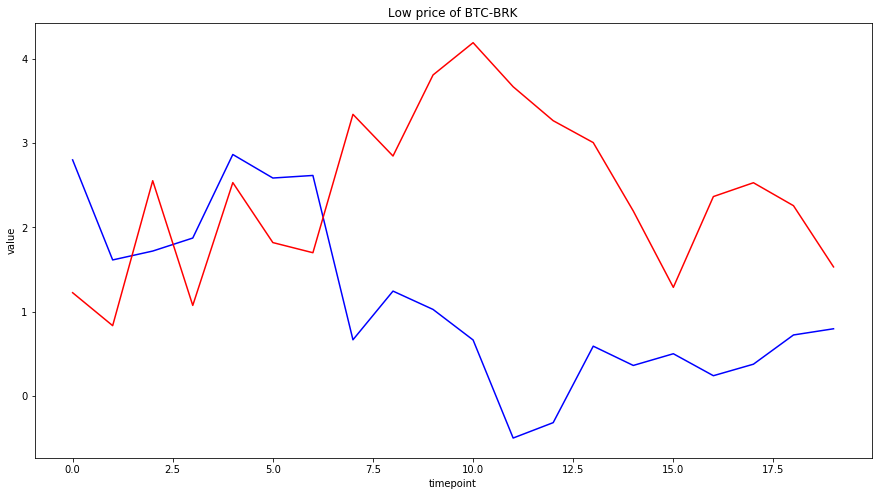

In [172]:
horizon = 20
check_idx = 95
model = TRMF(lags, rank, lambda_f, lambda_x, lambda_w, alpha, eta, 2000)
train, test = get_slice(data, T - horizon, horizon, 0)
model.fit(train)
predicted_data = model.predict(horizon)
draw_plot(test[check_idx, -horizon:], check_idx, predicted_data[check_idx])